# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle
import tensorflow as tf
import math
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
import cv2
import random
from sklearn.model_selection import train_test_split

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = str(X_train.shape[1]) + "x" + str(X_train.shape[2]) + "x" + str(X_train.shape[3])

output = set()
for x in y_train:
    output.add(x)

# TODO: how many classes are in the dataset
n_classes = len(output)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = 32x32x3
Number of classes = 43


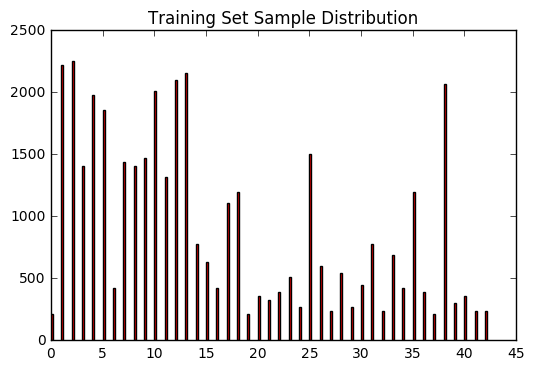

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import csv

def findsignnames(filename):
    signnames = []
    with open(filename, 'rt') as csvfile:
        signnamereader = csv.reader(csvfile)
        for row in signnamereader:
            signnames.append(row[1])
    signnames = signnames[1:]
    return signnames

'''For future use , extracting signnames'''
signnames = findsignnames('signnames.csv')

def displaysignnames(signnames):
    i=0
    for signname in signnames:
        print(str(i)+":"+signname)
        i+=1

class_set = np.zeros(n_classes)
for label in y_train:
    class_set[label] = class_set[label]+1


ind = np.arange(n_classes)
width = 0.2
fig, ax = plt.subplots()
ax.set_title('Training Set Sample Distribution')
rects1 = ax.bar(ind, class_set, width, color='r')

plt.show()

In [4]:
displaysignnames(signnames)

0:Speed limit (20km/h)
1:Speed limit (30km/h)
2:Speed limit (50km/h)
3:Speed limit (60km/h)
4:Speed limit (70km/h)
5:Speed limit (80km/h)
6:End of speed limit (80km/h)
7:Speed limit (100km/h)
8:Speed limit (120km/h)
9:No passing
10:No passing for vechiles over 3.5 metric tons
11:Right-of-way at the next intersection
12:Priority road
13:Yield
14:Stop
15:No vechiles
16:Vechiles over 3.5 metric tons prohibited
17:No entry
18:General caution
19:Dangerous curve to the left
20:Dangerous curve to the right
21:Double curve
22:Bumpy road
23:Slippery road
24:Road narrows on the right
25:Road work
26:Traffic signals
27:Pedestrians
28:Children crossing
29:Bicycles crossing
30:Beware of ice/snow
31:Wild animals crossing
32:End of all speed and passing limits
33:Turn right ahead
34:Turn left ahead
35:Ahead only
36:Go straight or right
37:Go straight or left
38:Keep right
39:Keep left
40:Roundabout mandatory
41:End of no passing
42:End of no passing by vechiles over 3.5 metric tons


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Sample Image


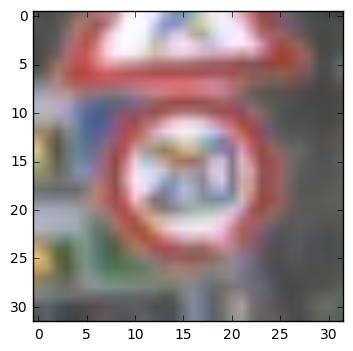

Before normalization
[[[ 75  78  80]
  [ 74  76  78]
  [ 83  84  83]
  ..., 
  [ 67  74  73]
  [ 65  69  68]
  [ 66  67  66]]

 [[ 82  83  85]
  [ 80  80  82]
  [ 87  86  83]
  ..., 
  [ 73  77  77]
  [ 75  77  75]
  [ 79  79  77]]

 [[ 79  79  81]
  [ 84  83  85]
  [ 91  88  89]
  ..., 
  [ 72  74  72]
  [ 74  75  71]
  [ 78  78  74]]

 ..., 
 [[126 128 133]
  [118 123 128]
  [108 117 120]
  ..., 
  [ 96  96  90]
  [ 99 101  94]
  [ 99 103  99]]

 [[ 90  94  98]
  [ 91  97 103]
  [ 77  87  92]
  ..., 
  [104 104  97]
  [107 111 102]
  [ 95 103  97]]

 [[ 85  84  87]
  [ 93  99 104]
  [ 69  80  85]
  ..., 
  [101 102  94]
  [ 98 101  90]
  [ 90  97  89]]]
After normalization
[[[ 0.29411765  0.30588235  0.31372549]
  [ 0.29019608  0.29803922  0.30588235]
  [ 0.3254902   0.32941176  0.3254902 ]
  ..., 
  [ 0.2627451   0.29019608  0.28627451]
  [ 0.25490196  0.27058824  0.26666667]
  [ 0.25882353  0.2627451   0.25882353]]

 [[ 0.32156863  0.3254902   0.33333333]
  [ 0.31372549  0.31372549

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print("Sample Image")
plt.imshow(X_train[0])
plt.show()

print("Before normalization")
print(X_train[0])

###Divide the image by 255 to normalize it between 0 and 1 

X_train = X_train/255.
X_test =  X_test/255.

print("After normalization")
print(X_train[0])

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [6]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

y_train_original = train['labels']
x_train_original = train['features']

def generate_y_data_map(y_train_original):
    i=0
    y_map = {}
    for y_data in y_train_original:
        if y_map.get(y_data)==None:
            y_map[y_data]={i}
        else:
            y_map[y_data].add(i)
        i+=1
    return y_map

y_map = generate_y_data_map(y_train_original)

mean = int(len(y_train_original)/43)
print(mean)


#Using this function from Udacity forum @ 
#https://carnd-udacity.atlassian.net/wiki/questions/10322627/project-2-unbalanced-data-generating-additional-data-by-jittering-the-original-image
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

#x_train_array = np.array(x_train_original).tolist()

#print(len(x_train_array))
#transformed_img = transform_image(X_train[0],10,10,1)
#x_train_original = np.append(x_train_original,transformed_img)


X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.05,
    random_state=832289)

911


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [71]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [8]:
### Train your model here.
### Feel free to use as many code cells as needed.



def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
    #layer = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    #layer = tf.nn.relu(layer, name=None)
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


learning_rate = 1e-6
training_epochs = 10
batch_size = 100
display_step = 10

n_input = 3072  #  data input (img shape: 32*32*3)
n_classes = 43  # total classes (43)

# input data is of type 32*32*3
x = tf.placeholder("float", [None, 32, 32, 3])

#x_flat = tf.reshape(x, [-1, 32,32,3])

### Layer 1 ###

W_conv1 = weight_variable([5, 5, 3, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

### Layer 2 ###
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

###Fully connected Layer 3 ###

W_fc1 = weight_variable([8 * 8 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

##Drop out layer###

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 43])
b_fc2 = bias_variable([43])

### Classifier ###
y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

y_ = tf.placeholder(tf.float32, shape=[None, n_classes])


learning_rate = 1e-6

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.clip_by_value(y_conv,1e-10,1.0)), 
                                              reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



####Training data, validation data and test data 
###keeping drop rate of 0.5 for training data, 1.0 for validation and test

train_feed_dict = {x: X_train, y_: y_train, keep_prob: 0.5}
valid_feed_dict = {x: X_valid, y_: y_valid, keep_prob: 1.0}
test_feed_dict = {x: X_test, y_: y_test, keep_prob: 1.0}
saver = tf.train.Saver()


In [17]:
with tf.Session() as session:
    session.run(tf.initialize_all_variables())

    batch_count = int(math.ceil(len(X_train)/batch_size))
    
    for epoch_i in range(2):
        #batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, training_epochs), unit='batches')
        #for batch_i in batches_pbar:
        # Get a batch of training features and labels
        for batch_i in range(100):
            batch_start = batch_i*batch_size
            batch_features = X_train[batch_start:batch_start + batch_size]
            batch_labels = y_train[batch_start:batch_start + batch_size]
            train_step.run(feed_dict={x: batch_features, y_: batch_labels, keep_prob: 0.5})

        if epoch_i % 10 == 0:
            train_accuracy = accuracy.eval(feed_dict=valid_feed_dict)
            batch_accuracy = accuracy.eval(feed_dict={x: batch_features, 
                                                          y_: batch_labels, 
                                                          keep_prob: 0.5})
            print("Epoch %d, training accuracy %g, batch accuracy %g "%(epoch_i, train_accuracy,batch_accuracy))
                
            print("test accuracy %g"%accuracy.eval(feed_dict=test_feed_dict))
        save_path = saver.save(session, "model.ckpt")
    
    print("Model saved in file: %s" % save_path)
    print("test accuracy %g"%accuracy.eval(feed_dict=test_feed_dict))


Epoch 0, training accuracy 0.285569, batch accuracy 0.19 
test accuracy 0.275455
Model saved in file: model.ckpt
test accuracy 0.387094


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


In [18]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "model.ckpt")
    print("Model restored.")
    print("test accuracy %g"%accuracy.eval(feed_dict=test_feed_dict))    

Model restored.
test accuracy 0.387094


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.